Reference paper: [Yoshua Bengio, Réjean Ducharme, Pascal Vincent, and Christian Jauvin. 2003. A Neural Probabilistic Language Model. J. Mach. Learn. Res. 3, (February 2003), 1137–1155.](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

One main difference in our implementation is that we are working with characters instead of words. The vocabulary size in the Bengio's paper is 17,000 words, whereas we are going to have a vocabulary of 27 characters (26 characters and the `<.>` special character).

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
words = open("./names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vacabulary of characters and mapping to/from integers
chars = sorted(list(set("".join(words))))
s2i = {s: i + 1 for i, s in enumerate(chars)}
s2i["."] = 0
i2s = {i: s for s, i in s2i.items()}
vocab_size = len(i2s)
print(i2s)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3  # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    x, y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = s2i[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]  # crop and append

    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

x_trn, y_trn = build_dataset(words[:n1])    # 80%
x_val, y_val = build_dataset(words[n1:n2])  # 10%
x_tst, y_tst = build_dataset(words[n2:])    # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn((vocab_size), generator=g)

parameters = [C, W1, b1, W2, b2]
print(f"Number of trainable parameters: {sum(p.nelement() for p in parameters)}")  # total number of parameters in the model

for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 11897


In [7]:
max_steps = 200_000
bs = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, x_trn.shape[0], (bs,), generator=g)
    xb, yb = x_trn[ix], y_trn[ix]

    # forward pass
    emb = C[xb]  # embed the characters into vectors
    emb_cat = emb.view((emb.shape[0], -1))  # concat the vectors
    h_pre_act = emb_cat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(h_pre_act)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad
        
    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.9417
  20000/ 200000: 2.5795
  30000/ 200000: 2.7819
  40000/ 200000: 2.0216
  50000/ 200000: 2.5858
  60000/ 200000: 2.3217
  70000/ 200000: 2.1007
  80000/ 200000: 2.2893
  90000/ 200000: 2.2368
 100000/ 200000: 1.9774
 110000/ 200000: 2.4507
 120000/ 200000: 1.9623
 130000/ 200000: 2.3657
 140000/ 200000: 2.2424
 150000/ 200000: 2.1469
 160000/ 200000: 2.2506
 170000/ 200000: 1.7543
 180000/ 200000: 2.1055
 190000/ 200000: 1.8174


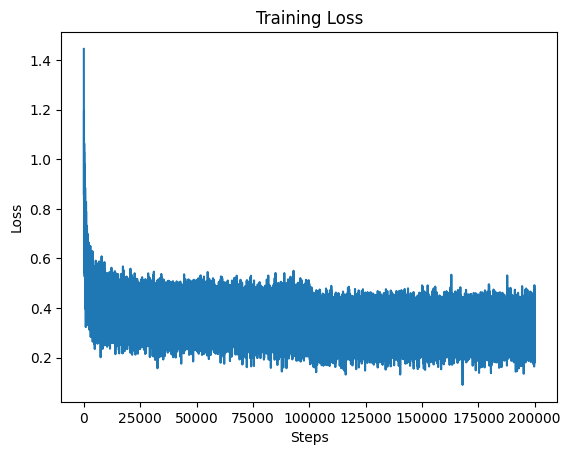

In [8]:
plt.plot(lossi)
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Steps")
plt.show()

In [9]:
@torch.no_grad()  # this decorator disable gradient tracking
def split_loss(split: str):
    x, y = {
        "train": (x_trn, y_trn),
        "val": (x_val, y_val),
        "test": (x_tst, y_tst),
    }[split]
    emb = C[x]  # (bs, block_size, n_embd)
    emb_cat = emb.view((emb.shape[0], -1))  # concat into (bs, block_size * n_embd)
    h_pre_act = emb_cat @ W1 + b1  # (bs, n_hidden)
    h = torch.tanh(h_pre_act)  # (bs, n_hidden)
    logits = h @ W2 + b2  # (bs, vocab_size)
    loss = F.cross_entropy(logits, y)  
    print(split, loss.item())

split_loss("train")
split_loss("val")

train 2.126697540283203
val 2.171041250228882


In [10]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass of the neural network
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if the special "." token break
        if ix == 0:
            break
            
    print("".join(i2s[i] for i in out))

mona.
mayah.
see.
mel.
ryllo.
emmadiengramira.
eredielin.
shy.
jen.
eden.
eson.
arleiyah.
hone.
cayshubergihimier.
kendreelynn.
nochorius.
macder.
yaque.
ehs.
kayjahsin.


## Debugging: The init

The loss we have after the first forward pass is too high, which is a red flag. This could have been caused by a poor initialization. We would expect an initial loss closer to $ - \log{\frac{1}{\text{vocab. lenght}}} = - \log{\frac{1}{27}} $. 

In [12]:
-torch.tensor(1/27).log()

tensor(3.2958)

To better understand what is happening, let's use an example using 4 classes.

In [45]:
# 4-d example of the issue
logits = torch.randn(4)
y_true = torch.tensor([0., 0., 1., 0.])
loss = F.cross_entropy(input=logits, target=y_true)
print(f"logits: {logits}\nloss: {loss}")

logits: tensor([ 0.6115, -0.7783, -0.2394,  1.3746])
loss: 2.1914122104644775


In [47]:
# 4-d example of the issue
logits = torch.randn(4) * 10  # <-- artificially increase the values of the logits 
y_true = torch.tensor([0., 0., 1., 0.])
loss = F.cross_entropy(input=logits, target=y_true)
print(f"logits: {logits}\nloss: {loss}")

logits: tensor([  4.3236,   3.2203, -11.5777,  -7.3739])
loss: 16.187833786010742


What is happening is that the logits generated by our model are too extreme at the beginning of the training process. This causes the loss to become extremely large in those cases when we are very confidently wrong (e.g., high logit for the wrong class, and low logits for the other classes). 

Let's inspect the logits after the first forward pass.

In [51]:
# MLP
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn((vocab_size), generator=g)

parameters = [C, W1, b1, W2, b2]
print(f"Number of trainable parameters: {sum(p.nelement() for p in parameters)}")  # total number of parameters in the model

for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 11897


In [54]:
max_steps = 200_000
bs = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, x_trn.shape[0], (bs,), generator=g)
    xb, yb = x_trn[ix], y_trn[ix]

    # forward pass
    emb = C[xb]  # embed the characters into vectors
    emb_cat = emb.view((emb.shape[0], -1))  # concat the vectors
    h_pre_act = emb_cat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(h_pre_act)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad
        
    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
        print(logits[0])
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 24.8074
tensor([  9.8607,   4.2133,  -4.9696,  -2.3298, -12.4576,  -7.3652,  -1.7257,
          0.4356,   5.5772,  -2.7682,  -7.0788,  -2.7884,  -5.8150,  -4.5269,
         11.5294,   7.0656, -35.1134,   7.3326,  15.4572, -11.8989, -17.4142,
         13.8119,  -5.6911,  -4.5338, -11.9642,   2.0828,  -1.8851],
       grad_fn=<SelectBackward0>)


To fix this, let's set `b2` to zeroes, and reduce the magnitude of the init values in the `W2` weight matrix.

In [58]:
# MLP
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  # not zero!
b2 = torch.randn((vocab_size), generator=g) * 0  # reset the bias term

parameters = [C, W1, b1, W2, b2]
print(f"Number of trainable parameters: {sum(p.nelement() for p in parameters)}")  # total number of parameters in the model

for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 11897


In [59]:
max_steps = 200_000
bs = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, x_trn.shape[0], (bs,), generator=g)
    xb, yb = x_trn[ix], y_trn[ix]

    # forward pass
    emb = C[xb]  # embed the characters into vectors
    emb_cat = emb.view((emb.shape[0], -1))  # concat the vectors
    h_pre_act = emb_cat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(h_pre_act)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad
        
    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
        print(logits[0])
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3221
tensor([-0.0249,  0.3523, -0.1267,  0.0541,  0.1662, -0.1171, -0.0140,  0.0124,
         0.0921,  0.1135,  0.1362, -0.0925,  0.0444, -0.2459, -0.0971,  0.0125,
        -0.0957, -0.1376, -0.2329, -0.0137,  0.2452,  0.1616,  0.1665, -0.1094,
        -0.2154,  0.0725,  0.1141], grad_fn=<SelectBackward0>)


This is much better, as the logits are more uniformly distributed, without extreme values. These are the logits from the very first forward pass, so it would be bad if they are heavily biased towards a particular output, as there hasn't been any learning yet (no backprop.).

Let's run the full optimization, not just the first forward pass.

In [62]:
# MLP
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  # not zero!
b2 = torch.randn((vocab_size), generator=g) * 0  # reset the bias term

parameters = [C, W1, b1, W2, b2]
print(f"Number of trainable parameters: {sum(p.nelement() for p in parameters)}")  # total number of parameters in the model

for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 11897


In [63]:
max_steps = 200_000
bs = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, x_trn.shape[0], (bs,), generator=g)
    xb, yb = x_trn[ix], y_trn[ix]

    # forward pass
    emb = C[xb]  # embed the characters into vectors
    emb_cat = emb.view((emb.shape[0], -1))  # concat the vectors
    h_pre_act = emb_cat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(h_pre_act)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad
        
    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8645
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


In [64]:
@torch.no_grad()  # this decorator disable gradient tracking
def split_loss(split: str):
    x, y = {
        "train": (x_trn, y_trn),
        "val": (x_val, y_val),
        "test": (x_tst, y_tst),
    }[split]
    emb = C[x]  # (bs, block_size, n_embd)
    emb_cat = emb.view((emb.shape[0], -1))  # concat into (bs, block_size * n_embd)
    h_pre_act = emb_cat @ W1 + b1  # (bs, n_hidden)
    h = torch.tanh(h_pre_act)  # (bs, n_hidden)
    logits = h @ W2 + b2  # (bs, vocab_size)
    loss = F.cross_entropy(logits, y)  
    print(split, loss.item())

split_loss("train")
split_loss("val")

train 2.069589138031006
val 2.1310744285583496


This is a significant improvement over the previous model! The reason for that is that we are spending more cycles learning instead of using the first few thousand iteration to squash down the weights to avoid extreme logits.

## Debugging: The hidden activation states

This time we are going to focus on the values of the hidden layer activations. There are taking on very extreme values, closer to $ -1.0 $ and $ 1.0 $.

In [65]:
# MLP
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  # not zero!
b2 = torch.randn((vocab_size), generator=g) * 0  # reset the bias term

parameters = [C, W1, b1, W2, b2]
print(f"Number of trainable parameters: {sum(p.nelement() for p in parameters)}")  # total number of parameters in the model

for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 11897


In [66]:
max_steps = 200_000
bs = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, x_trn.shape[0], (bs,), generator=g)
    xb, yb = x_trn[ix], y_trn[ix]

    # forward pass
    emb = C[xb]  # embed the characters into vectors
    emb_cat = emb.view((emb.shape[0], -1))  # concat the vectors
    h_pre_act = emb_cat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(h_pre_act)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad
        
    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
        print(h)
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3221
tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)
